# **CREATING MAIN DATASET**

In [1]:
  import pandas as pd
  import numpy as np
  import re
  import json
  import csv
  from io import StringIO
  from bs4 import BeautifulSoup
  import requests
  from fbprophet import Prophet
  params = {
    'range': '5y',
    'interval':'1d',
    'events':'history'
  }
  URL=('https://query1.finance.yahoo.com/v7/finance/download/GOOG?')
  response = requests.get(URL, params=params)
  file = StringIO(response.text)
  reader = csv.reader(file)
  data = pd.DataFrame(reader)
  data.columns = list(data.iloc[0])
  data = data.iloc[1:-1]
  data['Date']= pd.to_datetime(data['Date'])
  data
  data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1,2016-03-15,726.919983,732.289978,724.770020,728.330017,728.330017,1721000
2,2016-03-16,726.369995,737.469971,724.510010,736.090027,736.090027,1624400
3,2016-03-17,736.450012,743.070007,736.000000,737.780029,737.780029,1860800
4,2016-03-18,741.859985,742.000000,731.830017,737.599976,737.599976,2980700
5,2016-03-21,736.500000,742.500000,733.515991,742.090027,742.090027,1836500


In [2]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
1,2016-03-15,726.919983,732.289978,724.770020,728.330017,728.330017,1721000
2,2016-03-16,726.369995,737.469971,724.510010,736.090027,736.090027,1624400
3,2016-03-17,736.450012,743.070007,736.000000,737.780029,737.780029,1860800
4,2016-03-18,741.859985,742.000000,731.830017,737.599976,737.599976,2980700
5,2016-03-21,736.500000,742.500000,733.515991,742.090027,742.090027,1836500
...,...,...,...,...,...,...,...
1254,2021-03-08,2101.129883,2128.810059,2021.609985,2024.170044,2024.170044,1646000
1255,2021-03-09,2070.000000,2078.040039,2047.829956,2052.699951,2052.699951,1696400
1256,2021-03-10,2071.760010,2075.000000,2033.369995,2055.030029,2055.030029,1267800
1257,2021-03-11,2074.060059,2125.699951,2072.379883,2114.770020,2114.770020,1238300


# **BASIC PREDICTION**

In [2]:
def Stock_Prediction(URL):
  import pandas as pd
  import numpy as np
  import re
  import json
  import csv
  from io import StringIO
  from bs4 import BeautifulSoup
  import requests
  from fbprophet import Prophet
  params = {
    'range': '5y',
    'interval':'1d',
    'events':'history'
  }
  response = requests.get(URL, params=params)
  file = StringIO(response.text)
  reader = csv.reader(file)
  data = pd.DataFrame(reader)
  train=pd.DataFrame({'ds':data[0].iloc[1:],'y':data[4].iloc[1:]}) 
  train['ds']=pd.to_datetime(train['ds'])
  train=train.iloc[1:]
  New_month=[]
  for i in pd.DatetimeIndex(train['ds']).day:
      if(i>5):
        New_month.append(0)
      else:
        New_month.append(1)
  New_year=[]
  for i,j in zip(pd.DatetimeIndex(train['ds']).day,pd.DatetimeIndex(train['ds']).month):
    if(i==31 and j==12):
      New_year.append(1)
      
    elif(i>=1and i<5 and j==1):
      New_year.append(1)

    else:
      New_year.append(0)
  train['New_year']=New_year
  train['New_month']=New_month
  m=Prophet(changepoint_prior_scale=3,holidays_prior_scale=0.001,changepoint_range=1,n_changepoints=150)
  m.add_country_holidays(country_name='IN')
  #m.add_regressor('New_year')
  #m.add_regressor('New_month')
  m.fit(train)
  future=m.make_future_dataframe(periods=30)
  for i in pd.DatetimeIndex(future['ds'].iloc[len(train):]).day:
        if(i>5):
          New_month.append(0)
        else:
          New_month.append(1)
  for i,j in zip(pd.DatetimeIndex(future['ds'].iloc[len(train):]).day,pd.DatetimeIndex(future['ds'].iloc[len(train):]).month):
      if(i==31 and j==12):
        New_year.append(1)
        
      elif(i>=1and i<5 and j==1):
        New_year.append(1)

      else:
        New_year.append(0)

  df=pd.DataFrame({'ds':future['ds'],'New_year':New_year, 'New_month':New_month })
  forecast=m.predict(df)
  lower=[]
  upper=[]
  for i,j in zip(forecast['yhat_lower'],forecast['yhat']):
        lower.append(j-i)
  for i,j in zip(forecast['yhat_upper'],forecast['yhat']):
        upper.append(i-j)

  avg=[]
  for i,j in zip(lower,upper):
      avg.append((i+j)/2)
   

  error=[]
  for i,j in zip(forecast['yhat'].iloc[len(train):],avg[len(train):]):
        print(i,'+/-',j)
        error.append(j/i)
   
  return m.plot(forecast),pd.DataFrame({'ds':future['ds'].iloc[len(train):],'Predicted_Close':forecast['yhat'].iloc[len(train):],'Predicted_Close_Tolerance':avg[len(train):]}),np.array(error).mean(),max(error),min(error),avg,pd.DataFrame({'ds':future['ds'].iloc[:],'Predicted_Close':forecast['yhat'].iloc[:],'Predicted_Close_Tolerance':avg[:]})


### **CREATING OUTPUT**

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



2034.748841830024 +/- 30.179195657078935
2033.3718967241132 +/- 32.78747821569107
2029.9535750361592 +/- 30.458208492895324
2026.2729358807458 +/- 29.898266162174764
1995.9377791555612 +/- 30.965508072352918
1993.484070500152 +/- 30.5495559923404
2016.4692281718965 +/- 29.619813077172125
2016.0324369030916 +/- 31.90926662919128
2016.3540347918183 +/- 32.64919552614742
2014.7131676134795 +/- 32.16766547306577
2012.8638364607946 +/- 34.80511994538517
1984.3892018964336 +/- 33.47548004032092
1983.763009039879 +/- 36.31068461492987
2008.635688751912 +/- 35.3470373843237
2010.0102755375588 +/- 36.216359158284604
2012.08687186826 +/- 36.72839677673312
2012.083908621342 +/- 37.71208174171409
2011.8740749257242 +/- 39.97662861675133
1984.8962343655508 +/- 40.71639374609026
1985.697825932632 +/- 44.99717174087584
2011.807291688418 +/- 46.02702255645306
2014.3388994477252 +/- 47.05761428994799
2017.452270655188 +/- 46.55277255550743
2018.410059327351 +/- 50.581215596472475
2018.953914948759 +/- 

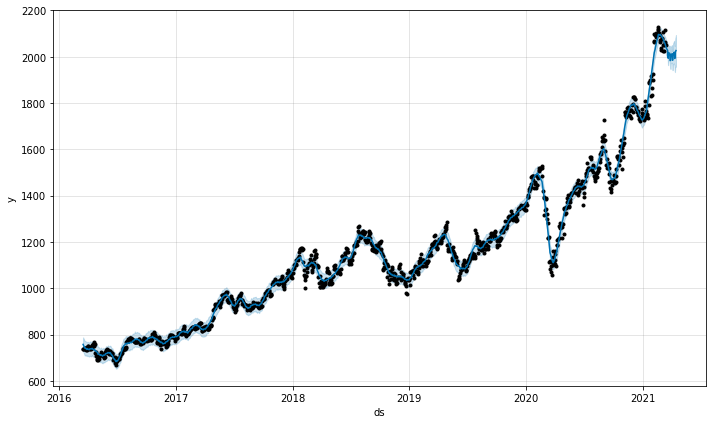

In [3]:
plot1,df1,mean_error_1,max_error_1,min_error_1,avg_error,full_df1=Stock_Prediction('https://query1.finance.yahoo.com/v7/finance/download/GOOG?')

### **OUTPUT**

In [4]:
max_error_1

0.033872905260552616

In [5]:
min_error_1

0.014688948714593104

In [6]:
mean_error_1

0.020506720082565835

In [7]:
avg_error

[30.45383518234479,
 30.04125993321628,
 30.3537063354064,
 31.278551136254464,
 31.350704260968996,
 29.80611154766609,
 30.37306299365497,
 30.151805359925334,
 28.71620687627484,
 30.557986984954994,
 29.6902865322038,
 30.829804209924816,
 29.935183920194106,
 30.46865703329098,
 30.798111059475104,
 30.57936746135266,
 31.27769205316463,
 31.326458720317476,
 30.431254102155208,
 29.91344466877331,
 30.31047398358737,
 29.25989095307318,
 30.039701012928845,
 30.247429502485147,
 31.536835956782056,
 32.58147218746814,
 30.071579892569503,
 29.548336509367402,
 30.01461714594808,
 30.68727375527851,
 29.332169349436754,
 29.626967540085957,
 30.245929229511376,
 30.533829325272336,
 30.010821982437164,
 29.13867315080273,
 30.3857912325621,
 28.999751560312745,
 30.01457062553709,
 29.811631491625803,
 30.40339955161761,
 31.293213495063867,
 30.512360601458283,
 30.31747829219131,
 32.122686786355644,
 29.531292759455823,
 30.735191216893384,
 29.75252675863743,
 29.9497448911291

### **Datasets**

In [8]:
full_df1

,ds,Predicted_Close,Predicted_Close_Tolerance
0,2016-03-16,757.715912,30.453835
1,2016-03-17,754.571805,30.041260
2,2016-03-18,751.149101,30.353706
3,2016-03-21,742.048281,31.278551
4,2016-03-22,741.831417,31.350704
...,...,...,...
1283,2021-04-10,1992.658603,54.238942
1284,2021-04-11,1994.031634,58.356178
1285,2021-04-12,2020.606644,61.826564
1286,2021-04-13,2023.503677,64.896206


In [9]:
df1

,ds,Predicted_Close,Predicted_Close_Tolerance
1258,2021-03-16,2034.748842,30.179196
1259,2021-03-17,2033.371897,32.787478
1260,2021-03-18,2029.953575,30.458208
1261,2021-03-19,2026.272936,29.898266
1262,2021-03-20,1995.937779,30.965508
1263,2021-03-21,1993.484071,30.549556
1264,2021-03-22,2016.469228,29.619813
1265,2021-03-23,2016.032437,31.909267
1266,2021-03-24,2016.354035,32.649196
1267,2021-03-25,2014.713168,32.167665


# **New Month & New Year**

In [10]:
def Stock_Prediction(URL):
  import pandas as pd
  import numpy as np
  import re
  import json
  import csv
  from io import StringIO
  from bs4 import BeautifulSoup
  import requests
  from fbprophet import Prophet
  params = {
    'range': '5y',
    'interval':'1d',
    'events':'history'
  }
  response = requests.get(URL, params=params)
  file = StringIO(response.text)
  reader = csv.reader(file)
  data = pd.DataFrame(reader)
  train=pd.DataFrame({'ds':data[0].iloc[1:],'y':data[4].iloc[1:]}) 
  train['ds']=pd.to_datetime(train['ds'])
  train=train.iloc[1:]
  New_month=[]
  for i in pd.DatetimeIndex(train['ds']).day:
      if(i>5):
        New_month.append(0)
      else:
        New_month.append(1)
  New_year=[]
  for i,j in zip(pd.DatetimeIndex(train['ds']).day,pd.DatetimeIndex(train['ds']).month):
    if(i==31 and j==12):
      New_year.append(1)
      
    elif(i>=1and i<5 and j==1):
      New_year.append(1)

    else:
      New_year.append(0)
  train['New_year']=New_year
  train['New_month']=New_month
  m=Prophet(changepoint_prior_scale=3,holidays_prior_scale=0.001,changepoint_range=1,n_changepoints=150)
  m.add_country_holidays(country_name='IN')
  m.add_regressor('New_year')
  m.add_regressor('New_month')
  m.fit(train)
  future=m.make_future_dataframe(periods=30)
  for i in pd.DatetimeIndex(future['ds'].iloc[len(train):]).day:
        if(i>5):
          New_month.append(0)
        else:
          New_month.append(1)
  for i,j in zip(pd.DatetimeIndex(future['ds'].iloc[len(train):]).day,pd.DatetimeIndex(future['ds'].iloc[len(train):]).month):
      if(i==31 and j==12):
        New_year.append(1)
        
      elif(i>=1and i<5 and j==1):
        New_year.append(1)

      else:
        New_year.append(0)

  df=pd.DataFrame({'ds':future['ds'],'New_year':New_year, 'New_month':New_month })
  forecast=m.predict(df)
  lower=[]
  upper=[]
  for i,j in zip(forecast['yhat_lower'],forecast['yhat']):
        lower.append(j-i)
  for i,j in zip(forecast['yhat_upper'],forecast['yhat']):
        upper.append(i-j)

  avg=[]
  for i,j in zip(lower,upper):
      avg.append((i+j)/2)
   

  error=[]
  for i,j in zip(forecast['yhat'].iloc[len(train):],avg[len(train):]):
        print(i,'+/-',j)
        error.append(j/i)
   
  return m.plot(forecast),pd.DataFrame({'Date':future['ds'].iloc[len(train):],'Predicted_Close_2':forecast['yhat'].iloc[len(train):],'Predicted_Close_2_Tolerance':avg[len(train):]}),np.array(error).mean(),max(error),min(error),avg,pd.DataFrame({'Date':future['ds'].iloc[:],'Predicted_Close_2':forecast['yhat'].iloc[:],'Predicted_Close_2_Tolerance':avg[:]})


### **CREATING OUTPUT**

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



2039.398112092625 +/- 30.168901776153234
2038.306755104853 +/- 31.281257377639804
2035.1190137654125 +/- 30.53072251452977
2031.8485577853405 +/- 30.426018362883042
2002.6226831077934 +/- 30.5251297585296
2000.4643506912719 +/- 31.915614235096996
2023.2887635695004 +/- 32.18957999368911
2022.7149582532961 +/- 32.26614305418855
2023.3549984106016 +/- 30.032218531403373
2021.9768346476328 +/- 33.93912908467075
2020.5684618021623 +/- 33.089891584156135
1993.2319532946676 +/- 33.08513271107768
1992.9652116046063 +/- 33.97316819814955
2017.662889138134 +/- 34.36111696258877
2018.920562722004 +/- 34.40928062950013
2021.332046393701 +/- 36.132127566336294
2020.4603697155933 +/- 37.39759315846425
2020.6939802471309 +/- 38.787236324665855
1994.8587528603246 +/- 40.94643839804917
1995.9825850586888 +/- 43.490958079646475
2021.951377199726 +/- 42.26901304221258
2025.5091164000576 +/- 44.530873876668124
2028.9470680857653 +/- 45.70027781960482
2030.1668731209334 +/- 47.66583577485096
2031.14446862

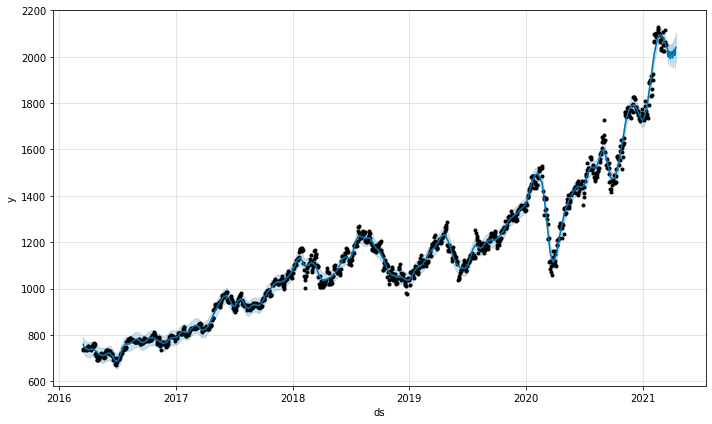

In [11]:
plot2,df2,mean_error_2,max_error_2,min_error_2,avg_error2,full_df2=Stock_Prediction('https://query1.finance.yahoo.com/v7/finance/download/GOOG?')

### **OUTPUT**

In [12]:
max_error_2

0.030894403384492477

In [13]:
min_error_2

0.01479304192607933

In [14]:
mean_error_2

0.01972468326882787

In [15]:
avg_error2

[30.17985561308126,
 30.058757954085593,
 31.947892902332796,
 31.178783828758014,
 31.82585551193438,
 31.326685989720943,
 31.346340102662964,
 30.919102424955383,
 31.35395618565775,
 30.65670269007279,
 28.5546632787499,
 31.77260577127805,
 31.665825868812647,
 31.03952058197416,
 30.798032166706093,
 30.660975037335447,
 30.884109557008856,
 32.0119773743661,
 30.10527525265718,
 30.284339787242118,
 30.2087296734872,
 30.664283191582115,
 32.50928145677733,
 32.61561877426067,
 29.50518619033221,
 30.709707789284778,
 31.379984954844304,
 31.881770542189486,
 28.732694122024327,
 29.853095709301215,
 31.39113163306638,
 31.92502693449552,
 31.264641002877227,
 30.750758344216877,
 32.24741146962572,
 31.72696934266611,
 31.805191177307904,
 30.644359125018184,
 30.892113047471412,
 30.740198388345107,
 31.933080586299695,
 31.630290778973176,
 31.807140585943273,
 32.09749806078804,
 31.934013546377116,
 29.372858270695644,
 29.496115743373252,
 30.003933406315525,
 30.056866535

### **Datasets**

In [16]:
full_df2

,Date,Predicted_Close_2,Predicted_Close_2_Tolerance
0,2016-03-16,759.642486,30.179856
1,2016-03-17,756.308984,30.058758
2,2016-03-18,752.876366,31.947893
3,2016-03-21,743.759141,31.178784
4,2016-03-22,742.985384,31.825856
...,...,...,...
1283,2021-04-10,2005.973963,53.532813
1284,2021-04-11,2007.649879,53.527561
1285,2021-04-12,2034.063819,57.878960
1286,2021-04-13,2036.816014,59.269973


In [17]:
df2

,Date,Predicted_Close_2,Predicted_Close_2_Tolerance
1258,2021-03-16,2039.398112,30.168902
1259,2021-03-17,2038.306755,31.281257
1260,2021-03-18,2035.119014,30.530723
1261,2021-03-19,2031.848558,30.426018
1262,2021-03-20,2002.622683,30.525130
1263,2021-03-21,2000.464351,31.915614
1264,2021-03-22,2023.288764,32.189580
1265,2021-03-23,2022.714958,32.266143
1266,2021-03-24,2023.354998,30.032219
1267,2021-03-25,2021.976835,33.939129


# **CHANGE PER DAY**

In [18]:
def Stock_Prediction(URL):
  import pandas as pd
  import numpy as np
  import re
  import json
  import csv
  from io import StringIO
  from bs4 import BeautifulSoup
  import requests
  from fbprophet import Prophet
  params = {
    'range': '5y',
    'interval':'1d',
    'events':'history'
  }
  response = requests.get(URL, params=params)
  file = StringIO(response.text)
  reader = csv.reader(file)
  data = pd.DataFrame(reader)
  train=pd.DataFrame({'ds':data[0].iloc[1:],'Open':data[1].iloc[1:],'High':data[2].iloc[1:],'Low':data[3].iloc[1:],'Close':data[4].iloc[1:],'Adj Close':data[5].iloc[1:],'Volume':data[6].iloc[1:]}) 
  train['ds']=pd.to_datetime(train['ds'])
  train['Close']=train['Close'].astype('float')
  train['y']=train['Close'].diff()
  train=train.iloc[1:]
  New_month=[]
  for i in pd.DatetimeIndex(train['ds']).day:
      if(i>5):
        New_month.append(0)
      else:
        New_month.append(1)
  New_year=[]
  for i,j in zip(pd.DatetimeIndex(train['ds']).day,pd.DatetimeIndex(train['ds']).month):
    if(i==31 and j==12):
      New_year.append(1)
      
    elif(i>=1and i<5 and j==1):
      New_year.append(1)

    else:
      New_year.append(0)
  train['New_year']=New_year
  train['New_month']=New_month
  m=Prophet(changepoint_prior_scale=3,holidays_prior_scale=0.001,changepoint_range=1,n_changepoints=150)
  m.add_country_holidays(country_name='IN')
  #m.add_regressor('New_year')
  #m.add_regressor('New_month')
  m.fit(train)
  future=m.make_future_dataframe(periods=30)
  for i in pd.DatetimeIndex(future['ds'].iloc[len(train):]).day:
        if(i>5):
          New_month.append(0)
        else:
          New_month.append(1)
  for i,j in zip(pd.DatetimeIndex(future['ds'].iloc[len(train):]).day,pd.DatetimeIndex(future['ds'].iloc[len(train):]).month):
      if(i==31 and j==12):
        New_year.append(1)
        
      elif(i>=1and i<5 and j==1):
        New_year.append(1)

      else:
        New_year.append(0)

  df=pd.DataFrame({'ds':future['ds']})
  forecast=m.predict(df)
  lower=[]
  upper=[]
  for i,j in zip(forecast['yhat_lower'],forecast['yhat']):
        lower.append(j-i)
  for i,j in zip(forecast['yhat_upper'],forecast['yhat']):
        upper.append(i-j)

  avg=[]
  for i,j in zip(lower,upper):
      avg.append((i+j)/2)
   

  error=[]
  for i,j in zip(forecast['yhat'].iloc[len(train):],avg[len(train):]):
        print(i,'+/-',j)
        error.append(j/i)
   
  return m.plot(forecast),pd.DataFrame({'Date':future['ds'].iloc[len(train):],'Predicted_Change':forecast['yhat'].iloc[len(train):],'Predicted_Change_Tolerance':avg[len(train):]}),np.array(error).mean(),max(error),min(error),avg,pd.DataFrame({'Date':future['ds'].iloc[:],'Predicted_Change':forecast['yhat'].iloc[:],'Predicted_Change_Tolerance':avg[:]})


### **CREATING OUTPUT**

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



0.9369747391474181 +/- 26.520423646386682
2.723178695612087 +/- 25.65382733939702
0.9551465294815564 +/- 27.348133878654703
0.9034574634647257 +/- 26.62821085599126
6.812882086762173 +/- 27.465466706006488
7.239582188142102 +/- 26.556370817205984
1.8411095626990672 +/- 26.132169946975587
3.7249342383275197 +/- 27.17584216658036
5.638974003644233 +/- 27.205656662578296
3.964270867724007 +/- 26.017416784634847
3.9716553900631815 +/- 26.36572209470613
9.906779267239472 +/- 25.920069980095732
10.325281841582742 +/- 26.43799617748692
4.892594844346126 +/- 25.820283413201924
6.712637164416328 +/- 25.413195864775606
8.53800982601137 +/- 24.206826391744674
6.753549704793385 +/- 26.5087731448034
6.630649579535018 +/- 28.532658783106015
12.420653658694626 +/- 27.271541054722025
12.683459495468142 +/- 26.833709581735445
7.081594220661712 +/- 27.92222137378079
8.7277475070542 +/- 27.219106743993315
10.375155474378985 +/- 26.35009561779355
8.410140180960282 +/- 26.974761421068123
8.108649587600965 

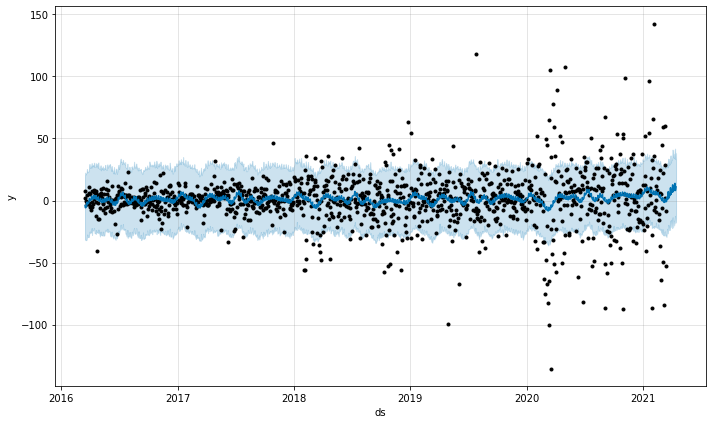

In [19]:
plot3,df3,mean_error_3,max_error_3,min_error_3,avg_error3,full_df3=Stock_Prediction('https://query1.finance.yahoo.com/v7/finance/download/GOOG?')

### **OUTPUT**

In [20]:
max_error_3

29.473674116181478

In [21]:
min_error_3

1.9622944426587912

In [22]:
mean_error_3

6.698964584747276

In [23]:
avg_error3

[26.928779380121224,
 26.23487523635358,
 26.843740051863413,
 26.9440007055968,
 27.461663162590945,
 25.728723714597308,
 26.157373836300323,
 26.526896195062182,
 27.144326363378006,
 27.436391580871067,
 25.92077984434335,
 26.328072624936624,
 26.87746238221758,
 25.9617844527776,
 26.149601265570407,
 27.783030707098067,
 26.331670912659362,
 26.30539191703019,
 25.519997359794015,
 26.352913416227686,
 26.928431082263813,
 26.656708103264528,
 26.66240086602855,
 28.186690335746412,
 26.959199597774774,
 26.611955778269962,
 27.654960007580478,
 26.01262255091237,
 28.361004707519193,
 27.0052495491003,
 25.8965950582816,
 25.775433348040735,
 27.05892999923778,
 26.722351534025275,
 26.69918567703583,
 25.92927337891372,
 27.163964915430263,
 27.257319047424332,
 26.429447893835807,
 26.301177818661344,
 26.724818351388052,
 26.537783342068565,
 27.052179844096422,
 25.402427854038613,
 26.754740404560465,
 26.55416194922659,
 24.321097808642435,
 24.8614516666084,
 26.19133679

### **Datasets**

In [24]:
full_df3

,Date,Predicted_Change,Predicted_Change_Tolerance
0,2016-03-16,-3.926020,26.928779
1,2016-03-17,-5.730299,26.234875
2,2016-03-18,-5.814713,26.843740
3,2016-03-21,-4.952620,26.944001
4,2016-03-22,-3.086342,27.461663
...,...,...,...
1283,2021-04-10,13.721182,27.535157
1284,2021-04-11,13.809837,27.098966
1285,2021-04-12,8.038177,25.622041
1286,2021-04-13,9.519627,25.609771


In [25]:
df3

,Date,Predicted_Change,Predicted_Change_Tolerance
1258,2021-03-16,0.936975,26.520424
1259,2021-03-17,2.723179,25.653827
1260,2021-03-18,0.955147,27.348134
1261,2021-03-19,0.903457,26.628211
1262,2021-03-20,6.812882,27.465467
1263,2021-03-21,7.239582,26.556371
1264,2021-03-22,1.841110,26.132170
1265,2021-03-23,3.724934,27.175842
1266,2021-03-24,5.638974,27.205657
1267,2021-03-25,3.964271,26.017417


# **PERCENTAGE CHANGE PER DAY**

In [26]:
def Stock_Prediction(URL):
  import pandas as pd
  import numpy as np
  import re
  import json
  import csv
  from io import StringIO
  from bs4 import BeautifulSoup
  import requests
  from fbprophet import Prophet
  params = {
    'range': '5y',
    'interval':'1d',
    'events':'history'
  }
  response = requests.get(URL, params=params)
  file = StringIO(response.text)
  reader = csv.reader(file)
  data = pd.DataFrame(reader)
  train=pd.DataFrame({'ds':data[0].iloc[1:],'Open':data[1].iloc[1:],'High':data[2].iloc[1:],'Low':data[3].iloc[1:],'Close':data[4].iloc[1:],'Adj Close':data[5].iloc[1:],'Volume':data[6].iloc[1:]}) 
  train['ds']=pd.to_datetime(train['ds'])
  train['Close']=train['Close'].astype('float')
  train['change_per_day']=train['Close'].diff()
  train=train.iloc[1:]
  train['y']=(train['change_per_day']/train['Close'])*100
  New_month=[]
  for i in pd.DatetimeIndex(train['ds']).day:
      if(i>5):
        New_month.append(0)
      else:
        New_month.append(1)
  New_year=[]
  for i,j in zip(pd.DatetimeIndex(train['ds']).day,pd.DatetimeIndex(train['ds']).month):
    if(i==31 and j==12):
      New_year.append(1)
      
    elif(i>=1and i<5 and j==1):
      New_year.append(1)

    else:
      New_year.append(0)
  train['New_year']=New_year
  train['New_month']=New_month
  m=Prophet(changepoint_prior_scale=3,holidays_prior_scale=0.001,changepoint_range=1,n_changepoints=150)
  m.add_country_holidays(country_name='IN')
  #m.add_regressor('New_year')
  #m.add_regressor('New_month')
  m.fit(train)
  future=m.make_future_dataframe(periods=30)
  for i in pd.DatetimeIndex(future['ds'].iloc[len(train):]).day:
        if(i>5):
          New_month.append(0)
        else:
          New_month.append(1)
  for i,j in zip(pd.DatetimeIndex(future['ds'].iloc[len(train):]).day,pd.DatetimeIndex(future['ds'].iloc[len(train):]).month):
      if(i==31 and j==12):
        New_year.append(1)
        
      elif(i>=1and i<5 and j==1):
        New_year.append(1)

      else:
        New_year.append(0)

  df=pd.DataFrame({'ds':future['ds']})
  forecast=m.predict(df)
  lower=[]
  upper=[]
  for i,j in zip(forecast['yhat_lower'],forecast['yhat']):
        lower.append(j-i)
  for i,j in zip(forecast['yhat_upper'],forecast['yhat']):
        upper.append(i-j)

  avg=[]
  for i,j in zip(lower,upper):
      avg.append((i+j)/2)
   

  error=[]
  for i,j in zip(forecast['yhat'].iloc[len(train):],avg[len(train):]):
        print(i,'+/-',j)
        error.append(j/i)
   
  return m.plot(forecast),pd.DataFrame({'Date':future['ds'].iloc[len(train):],'Predicted_PercentChange':forecast['yhat'].iloc[len(train):],'Predicted_PercentChange_Tolerance':avg[len(train):]}),np.array(error).mean(),max(error),min(error),avg,pd.DataFrame({'Date':future['ds'].iloc[:],'Predicted_PercentChange':forecast['yhat'].iloc[:],'Predicted_PercentChange_Tolerance':avg[:]})


### **CREATING OUTPUT**

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



-0.14004957075488778 +/- 2.237531120598452
-0.018246765421185973 +/- 2.0120375487000928
-0.16972272225166973 +/- 2.2244671678632058
-0.1694565701233598 +/- 2.0106121724465917
0.5488509392647832 +/- 2.130943829114353
0.5849310637862842 +/- 2.1557970654904697
-0.06846638128643978 +/- 2.0375992266805145
0.08404511855039154 +/- 2.133922208693253
0.22702145330698514 +/- 2.1673053800637785
0.09319336604222322 +/- 2.1235360412560533
0.10740026243395867 +/- 2.1296574352737414
0.8358382068249683 +/- 2.101636463623295
0.878022279961332 +/- 2.175007236160656
0.22732038942369237 +/- 2.169425510188192
0.37866610965294367 +/- 2.152860008389286
0.5169857964151225 +/- 2.229370993416471
0.37535084690463827 +/- 2.0829758063477803
0.37857084565580645 +/- 2.1197194880033177
1.0934772447329655 +/- 2.192192570529116
1.1200215955392292 +/- 2.1658861613695586
0.4513718496988496 +/- 2.1021168387984646
0.583411904834702 +/- 2.0942621244526753
0.701259106462751 +/- 2.0337058600581575
0.5382539665825334 +/- 2.109

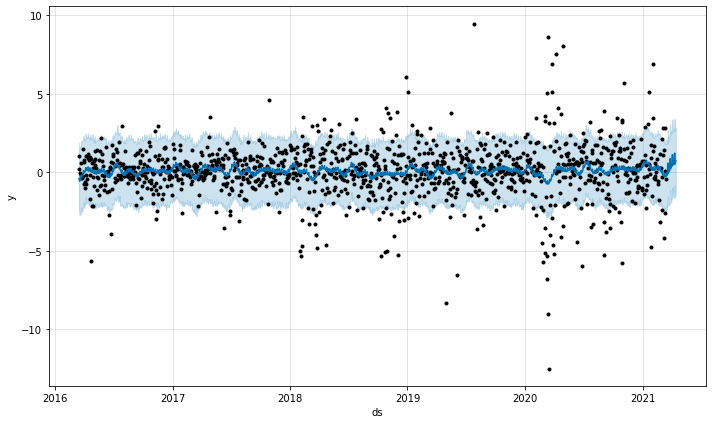

In [27]:
plot4,df4,mean_error_4,max_error_4,min_error_4,avg_error4,full_df4=Stock_Prediction('https://query1.finance.yahoo.com/v7/finance/download/GOOG?')

### **OUTPUT**

In [28]:
max_error_4

25.390198092394883

In [29]:
min_error_4

-110.26817642780425

In [30]:
mean_error_4

-0.7804419188567455

In [31]:
avg_error4

[2.1213248577194217,
 2.0947683247032636,
 2.157496142991051,
 2.1180980057252325,
 2.104703962992178,
 2.0987727519718495,
 2.226689193606571,
 2.21025499400475,
 2.1283377993153305,
 2.111533368578666,
 2.072028038364059,
 2.1999042762415164,
 2.0113600271129704,
 2.186826437414508,
 2.0274209808921504,
 2.0836301996304574,
 2.1339814464111795,
 2.0436887191592223,
 2.1446609299707853,
 2.078017904713092,
 2.079901949455428,
 2.18036485338764,
 2.0140052008400464,
 2.186934076103396,
 2.116248444154039,
 2.1724914725213127,
 2.113984114141663,
 2.06545331433416,
 2.1218798966110297,
 2.159447087249927,
 2.1094450765748314,
 2.093396386959634,
 2.241697062267116,
 2.011967116900437,
 2.1156407178288497,
 2.1291990739963333,
 2.1248124785270983,
 2.0645360011292473,
 2.0537772641889704,
 2.060819533054985,
 2.1305448034522074,
 2.145469431220178,
 2.1357223773440195,
 2.0844306837116813,
 2.0897712687151673,
 2.1253292164574376,
 2.167181794486339,
 2.207101838590904,
 2.13200074082290

### **Datasets**

In [32]:
full_df4

,Date,Predicted_PercentChange,Predicted_PercentChange_Tolerance
0,2016-03-16,-0.395024,2.121325
1,2016-03-17,-0.551069,2.094768
2,2016-03-18,-0.555080,2.157496
3,2016-03-21,-0.464777,2.118098
4,2016-03-22,-0.315023,2.104704
...,...,...,...
1283,2021-04-10,1.212987,2.102079
1284,2021-04-11,1.217946,2.109622
1285,2021-04-12,0.528203,2.173617
1286,2021-04-13,0.639886,2.161993


In [33]:
df4

,Date,Predicted_PercentChange,Predicted_PercentChange_Tolerance
1258,2021-03-16,-0.140050,2.237531
1259,2021-03-17,-0.018247,2.012038
1260,2021-03-18,-0.169723,2.224467
1261,2021-03-19,-0.169457,2.010612
1262,2021-03-20,0.548851,2.130944
1263,2021-03-21,0.584931,2.155797
1264,2021-03-22,-0.068466,2.037599
1265,2021-03-23,0.084045,2.133922
1266,2021-03-24,0.227021,2.167305
1267,2021-03-25,0.093193,2.123536


# **VOLUME PREDICTION**

In [34]:
def Stock_Prediction(URL):
  import pandas as pd
  import numpy as np
  import re
  import json
  import csv
  from io import StringIO
  from bs4 import BeautifulSoup
  import requests
  from fbprophet import Prophet
  params = {
    'range': '5y',
    'interval':'1d',
    'events':'history'
  }
  response = requests.get(URL, params=params)
  file = StringIO(response.text)
  reader = csv.reader(file)
  data = pd.DataFrame(reader)
  train=pd.DataFrame({'ds':data[0].iloc[1:],'Open':data[1].iloc[1:],'High':data[2].iloc[1:],'Low':data[3].iloc[1:],'Close':data[4].iloc[1:],'Adj Close':data[5].iloc[1:],'y':data[6].iloc[1:]}) 

  train['ds']=pd.to_datetime(train['ds'])
  train=train.iloc[1:]
  New_month=[]
  for i in pd.DatetimeIndex(train['ds']).day:
      if(i>5):
        New_month.append(0)
      else:
        New_month.append(1)
  New_year=[]
  for i,j in zip(pd.DatetimeIndex(train['ds']).day,pd.DatetimeIndex(train['ds']).month):
    if(i==31 and j==12):
      New_year.append(1)
      
    elif(i>=1and i<5 and j==1):
      New_year.append(1)

    else:
      New_year.append(0)
  train['New_year']=New_year
  train['New_month']=New_month
  m=Prophet(changepoint_prior_scale=3,holidays_prior_scale=0.001,changepoint_range=1,n_changepoints=150)
  m.add_country_holidays(country_name='IN')
  #m.add_regressor('New_year')
  #m.add_regressor('New_month')
  m.fit(train)
  future=m.make_future_dataframe(periods=30)
  for i in pd.DatetimeIndex(future['ds'].iloc[len(train):]).day:
        if(i>5):
          New_month.append(0)
        else:
          New_month.append(1)
  for i,j in zip(pd.DatetimeIndex(future['ds'].iloc[len(train):]).day,pd.DatetimeIndex(future['ds'].iloc[len(train):]).month):
      if(i==31 and j==12):
        New_year.append(1)
        
      elif(i>=1and i<5 and j==1):
        New_year.append(1)

      else:
        New_year.append(0)

  df=pd.DataFrame({'ds':future['ds'],'New_year':New_year, 'New_month':New_month })
  forecast=m.predict(df)
  lower=[]
  upper=[]
  for i,j in zip(forecast['yhat_lower'],forecast['yhat']):
        lower.append(j-i)
  for i,j in zip(forecast['yhat_upper'],forecast['yhat']):
        upper.append(i-j)

  avg=[]
  for i,j in zip(lower,upper):
      avg.append((i+j)/2)
   

  error=[]
  for i,j in zip(forecast['yhat'].iloc[len(train):],avg[len(train):]):
        print(i,'+/-',j)
        error.append(j/i)
   
  return m.plot(forecast),pd.DataFrame({'Date':future['ds'].iloc[len(train):],'Predicted_Volume':forecast['yhat'].iloc[len(train):],'Predicted_Volume_Tolerance':avg[len(train):]}),np.array(error).mean(),max(error),min(error),avg,pd.DataFrame({'Date':future['ds'].iloc[:],'Predicted_Volume':forecast['yhat'].iloc[:],'Predicted_Volume_Tolerance':avg[:]})


### **CREATING OUTPUT**

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



1907804.518250434 +/- 754847.3890376544
1870895.6477252685 +/- 729009.8318254531
1885632.4563449416 +/- 757915.8120416721
2076288.090057115 +/- 770311.8929185214
1816123.9253897797 +/- 788609.1511448922
1791273.2486171578 +/- 773124.3002562597
1837649.7769330894 +/- 818514.4314340997
1789245.5231827148 +/- 752728.2437705998
1702521.091120348 +/- 721896.3391112376
1670148.4992365367 +/- 762050.3678043238
1817318.6491837464 +/- 779641.8548137762
1518136.321360022 +/- 742035.4023822239
1459427.907536874 +/- 750949.4607037848
1477922.075186682 +/- 785823.3963894784
1407956.732553708 +/- 739115.5608214275
1306434.8901194236 +/- 771141.9644029168
1266308.3026608145 +/- 746105.2403572719
1412748.8049227998 +/- 775113.1426504444
1119918.258748273 +/- 731261.1511031869
1074458.1906404793 +/- 786798.9729304821
1112575.027405476 +/- 793147.5520104561
1068293.972033759 +/- 780079.3888482337
997848.6779725242 +/- 790334.9312296509
993429.1463255613 +/- 794233.5850482645
1179499.8605221154 +/- 77808

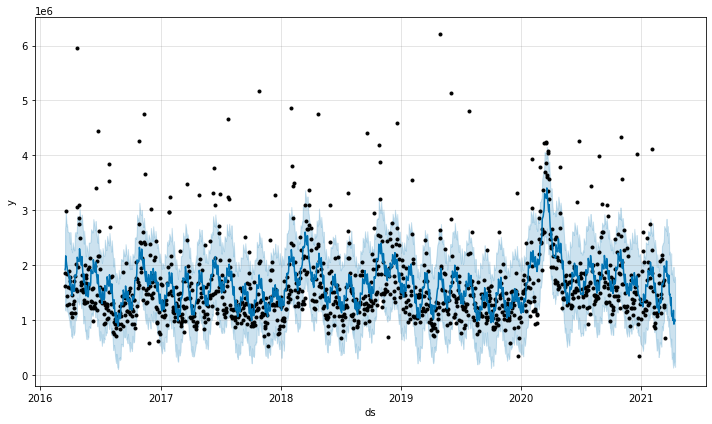

In [35]:
plot5,df5,mean_error_5,max_error_5,min_error_5,avg_error5,full_df5=Stock_Prediction('https://query1.finance.yahoo.com/v7/finance/download/GOOG?')

### **OUTPUT**

In [36]:
max_error_5

0.8193766118902172

In [37]:
min_error_5

0.3710043402008492

In [38]:
mean_error_5

0.58150385489844

In [39]:
avg_error5

[745989.1199777792,
 772486.0989221338,
 764534.0503561915,
 771853.2661485096,
 753498.4778587212,
 760955.7957837388,
 731202.0168157549,
 785501.1374558592,
 799931.4497998303,
 751719.5872903693,
 763662.1154946573,
 804591.7091858124,
 791673.1585426189,
 775610.4404214667,
 778314.6000318896,
 794962.9885774151,
 758887.9474668305,
 781106.7872047122,
 791730.4190121315,
 751307.5093747117,
 779702.5531445263,
 764522.7022932394,
 764094.2858004293,
 762589.9006834374,
 757546.3713055144,
 784491.2248113913,
 745240.6795528119,
 744798.7189472581,
 759537.2108474998,
 779394.4388011885,
 745832.5764966989,
 729212.4467106819,
 739934.1337220861,
 777478.0508705055,
 744366.9189511982,
 817867.8969338834,
 785238.6004538037,
 760014.9741842157,
 795838.3603347444,
 786676.1399556749,
 714578.7596012168,
 777447.270831025,
 791717.6608305536,
 714735.0938497819,
 707055.2663735929,
 764436.6645305548,
 766202.5413631017,
 807890.2926392904,
 767122.4611762154,
 744702.431841525,
 7

### **Datasets**

In [40]:
full_df5

,Date,Predicted_Volume,Predicted_Volume_Tolerance
0,2016-03-16,1.917654e+06,745989.119978
1,2016-03-17,1.956191e+06,772486.098922
2,2016-03-18,2.170666e+06,764534.050356
3,2016-03-21,2.002470e+06,771853.266149
4,2016-03-22,1.976850e+06,753498.477859
...,...,...,...
1283,2021-04-10,9.292108e+05,761301.660088
1284,2021-04-11,9.282840e+05,760614.166972
1285,2021-04-12,1.011931e+06,782238.920605
1286,2021-04-13,1.013167e+06,771359.915451


In [41]:
df5

,Date,Predicted_Volume,Predicted_Volume_Tolerance
1258,2021-03-16,1.907805e+06,754847.389038
1259,2021-03-17,1.870896e+06,729009.831825
1260,2021-03-18,1.885632e+06,757915.812042
1261,2021-03-19,2.076288e+06,770311.892919
1262,2021-03-20,1.816124e+06,788609.151145
1263,2021-03-21,1.791273e+06,773124.300256
1264,2021-03-22,1.837650e+06,818514.431434
1265,2021-03-23,1.789246e+06,752728.243771
1266,2021-03-24,1.702521e+06,721896.339111
1267,2021-03-25,1.670148e+06,762050.367804


# **BIG DATASET**

In [42]:
frames_full=[full_df1,full_df2,full_df3,full_df4,full_df5]

In [43]:
big_dataset_full=pd.concat(frames_full,axis=1)

In [44]:
big_dataset_full

,ds,Predicted_Close,Predicted_Close_Tolerance,Date,Predicted_Close_2,Predicted_Close_2_Tolerance,Date,Predicted_Change,Predicted_Change_Tolerance,Date,Predicted_PercentChange,Predicted_PercentChange_Tolerance,Date,Predicted_Volume,Predicted_Volume_Tolerance
0,2016-03-16,757.715912,30.453835,2016-03-16,759.642486,30.179856,2016-03-16,-3.926020,26.928779,2016-03-16,-0.395024,2.121325,2016-03-16,1.917654e+06,745989.119978
1,2016-03-17,754.571805,30.041260,2016-03-17,756.308984,30.058758,2016-03-17,-5.730299,26.234875,2016-03-17,-0.551069,2.094768,2016-03-17,1.956191e+06,772486.098922
2,2016-03-18,751.149101,30.353706,2016-03-18,752.876366,31.947893,2016-03-18,-5.814713,26.843740,2016-03-18,-0.555080,2.157496,2016-03-18,2.170666e+06,764534.050356
3,2016-03-21,742.048281,31.278551,2016-03-21,743.759141,31.178784,2016-03-21,-4.952620,26.944001,2016-03-21,-0.464777,2.118098,2016-03-21,2.002470e+06,771853.266149
4,2016-03-22,741.831417,31.350704,2016-03-22,742.985384,31.825856,2016-03-22,-3.086342,27.461663,2016-03-22,-0.315023,2.104704,2016-03-22,1.976850e+06,753498.477859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,2021-04-10,1992.658603,54.238942,2021-04-10,2005.973963,53.532813,2021-04-10,13.721182,27.535157,2021-04-10,1.212987,2.102079,2021-04-10,9.292108e+05,761301.660088
1284,2021-04-11,1994.031634,58.356178,2021-04-11,2007.649879,53.527561,2021-04-11,13.809837,27.098966,2021-04-11,1.217946,2.109622,2021-04-11,9.282840e+05,760614.166972
1285,2021-04-12,2020.606644,61.826564,2021-04-12,2034.063819,57.878960,2021-04-12,8.038177,25.622041,2021-04-12,0.528203,2.173617,2021-04-12,1.011931e+06,782238.920605
1286,2021-04-13,2023.503677,64.896206,2021-04-13,2036.816014,59.269973,2021-04-13,9.519627,25.609771,2021-04-13,0.639886,2.161993,2021-04-13,1.013167e+06,771359.915451


# **MAIN MODEL**

In [45]:
df=big_dataset_full.copy()
df.drop('Date',axis=1,inplace=True)

In [46]:
New_month1=[]
for i in pd.DatetimeIndex(df['ds']).day:
  if(i>5):
    New_month1.append(0)
  else:
    New_month1.append(1)

New_year1=[]
for i,j in zip(pd.DatetimeIndex(df['ds']).day,pd.DatetimeIndex(df['ds']).month):
  if(i==31 and j==12):
    New_year1.append(1)
    
  elif(i>=1and i<5 and j==1):
    New_year1.append(1)

  else:
    New_year1.append(0)

df['New_year']=New_year1
df['New_month']=New_month1

In [47]:
df

,ds,Predicted_Close,Predicted_Close_Tolerance,Predicted_Close_2,Predicted_Close_2_Tolerance,Predicted_Change,Predicted_Change_Tolerance,Predicted_PercentChange,Predicted_PercentChange_Tolerance,Predicted_Volume,Predicted_Volume_Tolerance,New_year,New_month
0,2016-03-16,757.715912,30.453835,759.642486,30.179856,-3.926020,26.928779,-0.395024,2.121325,1.917654e+06,745989.119978,0,0
1,2016-03-17,754.571805,30.041260,756.308984,30.058758,-5.730299,26.234875,-0.551069,2.094768,1.956191e+06,772486.098922,0,0
2,2016-03-18,751.149101,30.353706,752.876366,31.947893,-5.814713,26.843740,-0.555080,2.157496,2.170666e+06,764534.050356,0,0
3,2016-03-21,742.048281,31.278551,743.759141,31.178784,-4.952620,26.944001,-0.464777,2.118098,2.002470e+06,771853.266149,0,0
4,2016-03-22,741.831417,31.350704,742.985384,31.825856,-3.086342,27.461663,-0.315023,2.104704,1.976850e+06,753498.477859,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,2021-04-10,1992.658603,54.238942,2005.973963,53.532813,13.721182,27.535157,1.212987,2.102079,9.292108e+05,761301.660088,0,0
1284,2021-04-11,1994.031634,58.356178,2007.649879,53.527561,13.809837,27.098966,1.217946,2.109622,9.282840e+05,760614.166972,0,0
1285,2021-04-12,2020.606644,61.826564,2034.063819,57.878960,8.038177,25.622041,0.528203,2.173617,1.011931e+06,782238.920605,0,0
1286,2021-04-13,2023.503677,64.896206,2036.816014,59.269973,9.519627,25.609771,0.639886,2.161993,1.013167e+06,771359.915451,0,0


In [48]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
1,2016-03-15,726.919983,732.289978,724.770020,728.330017,728.330017,1721000
2,2016-03-16,726.369995,737.469971,724.510010,736.090027,736.090027,1624400
3,2016-03-17,736.450012,743.070007,736.000000,737.780029,737.780029,1860800
4,2016-03-18,741.859985,742.000000,731.830017,737.599976,737.599976,2980700
5,2016-03-21,736.500000,742.500000,733.515991,742.090027,742.090027,1836500
...,...,...,...,...,...,...,...
1254,2021-03-08,2101.129883,2128.810059,2021.609985,2024.170044,2024.170044,1646000
1255,2021-03-09,2070.000000,2078.040039,2047.829956,2052.699951,2052.699951,1696400
1256,2021-03-10,2071.760010,2075.000000,2033.369995,2055.030029,2055.030029,1267800
1257,2021-03-11,2074.060059,2125.699951,2072.379883,2114.770020,2114.770020,1238300


In [49]:
data.reset_index(inplace=True)
data.drop('index',axis=1,inplace=True)
# data=data.iloc[1:]
# data.reset_index(inplace=True)
# data.drop('index',axis=1,inplace=True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-15,726.919983,732.289978,724.770020,728.330017,728.330017,1721000
1,2016-03-16,726.369995,737.469971,724.510010,736.090027,736.090027,1624400
2,2016-03-17,736.450012,743.070007,736.000000,737.780029,737.780029,1860800
3,2016-03-18,741.859985,742.000000,731.830017,737.599976,737.599976,2980700
4,2016-03-21,736.500000,742.500000,733.515991,742.090027,742.090027,1836500
...,...,...,...,...,...,...,...
1253,2021-03-08,2101.129883,2128.810059,2021.609985,2024.170044,2024.170044,1646000
1254,2021-03-09,2070.000000,2078.040039,2047.829956,2052.699951,2052.699951,1696400
1255,2021-03-10,2071.760010,2075.000000,2033.369995,2055.030029,2055.030029,1267800
1256,2021-03-11,2074.060059,2125.699951,2072.379883,2114.770020,2114.770020,1238300


In [50]:
len(data)

1258

In [51]:
train=df.iloc[:len(data)]
train

,ds,Predicted_Close,Predicted_Close_Tolerance,Predicted_Close_2,Predicted_Close_2_Tolerance,Predicted_Change,Predicted_Change_Tolerance,Predicted_PercentChange,Predicted_PercentChange_Tolerance,Predicted_Volume,Predicted_Volume_Tolerance,New_year,New_month
0,2016-03-16,757.715912,30.453835,759.642486,30.179856,-3.926020,26.928779,-0.395024,2.121325,1.917654e+06,745989.119978,0,0
1,2016-03-17,754.571805,30.041260,756.308984,30.058758,-5.730299,26.234875,-0.551069,2.094768,1.956191e+06,772486.098922,0,0
2,2016-03-18,751.149101,30.353706,752.876366,31.947893,-5.814713,26.843740,-0.555080,2.157496,2.170666e+06,764534.050356,0,0
3,2016-03-21,742.048281,31.278551,743.759141,31.178784,-4.952620,26.944001,-0.464777,2.118098,2.002470e+06,771853.266149,0,0
4,2016-03-22,741.831417,31.350704,742.985384,31.825856,-3.086342,27.461663,-0.315023,2.104704,1.976850e+06,753498.477859,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2021-03-09,2061.195434,30.331433,2064.010518,31.727542,-0.112916,26.018915,-0.147643,2.093649,1.685109e+06,729385.715817,0,0
1254,2021-03-10,2059.298707,29.537597,2062.378098,30.663946,1.354381,25.685893,-0.060687,2.140798,1.689341e+06,747030.055969,0,0
1255,2021-03-11,2055.138696,29.692589,2058.424217,31.320053,-0.715308,27.798268,-0.246637,2.137281,1.749282e+06,760511.358564,0,0
1256,2021-03-12,2050.507823,30.799578,2054.176312,32.067313,-1.047045,26.659362,-0.279873,2.191208,1.988347e+06,755535.692703,0,0


In [52]:
test=df.iloc[len(data):]
test

,ds,Predicted_Close,Predicted_Close_Tolerance,Predicted_Close_2,Predicted_Close_2_Tolerance,Predicted_Change,Predicted_Change_Tolerance,Predicted_PercentChange,Predicted_PercentChange_Tolerance,Predicted_Volume,Predicted_Volume_Tolerance,New_year,New_month
1258,2021-03-16,2034.748842,30.179196,2039.398112,30.168902,0.936975,26.520424,-0.140050,2.237531,1.907805e+06,754847.389038,0,0
1259,2021-03-17,2033.371897,32.787478,2038.306755,31.281257,2.723179,25.653827,-0.018247,2.012038,1.870896e+06,729009.831825,0,0
1260,2021-03-18,2029.953575,30.458208,2035.119014,30.530723,0.955147,27.348134,-0.169723,2.224467,1.885632e+06,757915.812042,0,0
1261,2021-03-19,2026.272936,29.898266,2031.848558,30.426018,0.903457,26.628211,-0.169457,2.010612,2.076288e+06,770311.892919,0,0
1262,2021-03-20,1995.937779,30.965508,2002.622683,30.525130,6.812882,27.465467,0.548851,2.130944,1.816124e+06,788609.151145,0,0
1263,2021-03-21,1993.484071,30.549556,2000.464351,31.915614,7.239582,26.556371,0.584931,2.155797,1.791273e+06,773124.300256,0,0
1264,2021-03-22,2016.469228,29.619813,2023.288764,32.189580,1.841110,26.132170,-0.068466,2.037599,1.837650e+06,818514.431434,0,0
1265,2021-03-23,2016.032437,31.909267,2022.714958,32.266143,3.724934,27.175842,0.084045,2.133922,1.789246e+06,752728.243771,0,0
1266,2021-03-24,2016.354035,32.649196,2023.354998,30.032219,5.638974,27.205657,0.227021,2.167305,1.702521e+06,721896.339111,0,0
1267,2021-03-25,2014.713168,32.167665,2021.976835,33.939129,3.964271,26.017417,0.093193,2.123536,1.670148e+06,762050.367804,0,0


In [53]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-15,726.919983,732.289978,724.770020,728.330017,728.330017,1721000
1,2016-03-16,726.369995,737.469971,724.510010,736.090027,736.090027,1624400
2,2016-03-17,736.450012,743.070007,736.000000,737.780029,737.780029,1860800
3,2016-03-18,741.859985,742.000000,731.830017,737.599976,737.599976,2980700
4,2016-03-21,736.500000,742.500000,733.515991,742.090027,742.090027,1836500
...,...,...,...,...,...,...,...
1253,2021-03-08,2101.129883,2128.810059,2021.609985,2024.170044,2024.170044,1646000
1254,2021-03-09,2070.000000,2078.040039,2047.829956,2052.699951,2052.699951,1696400
1255,2021-03-10,2071.760010,2075.000000,2033.369995,2055.030029,2055.030029,1267800
1256,2021-03-11,2074.060059,2125.699951,2072.379883,2114.770020,2114.770020,1238300


In [54]:
train

,ds,Predicted_Close,Predicted_Close_Tolerance,Predicted_Close_2,Predicted_Close_2_Tolerance,Predicted_Change,Predicted_Change_Tolerance,Predicted_PercentChange,Predicted_PercentChange_Tolerance,Predicted_Volume,Predicted_Volume_Tolerance,New_year,New_month
0,2016-03-16,757.715912,30.453835,759.642486,30.179856,-3.926020,26.928779,-0.395024,2.121325,1.917654e+06,745989.119978,0,0
1,2016-03-17,754.571805,30.041260,756.308984,30.058758,-5.730299,26.234875,-0.551069,2.094768,1.956191e+06,772486.098922,0,0
2,2016-03-18,751.149101,30.353706,752.876366,31.947893,-5.814713,26.843740,-0.555080,2.157496,2.170666e+06,764534.050356,0,0
3,2016-03-21,742.048281,31.278551,743.759141,31.178784,-4.952620,26.944001,-0.464777,2.118098,2.002470e+06,771853.266149,0,0
4,2016-03-22,741.831417,31.350704,742.985384,31.825856,-3.086342,27.461663,-0.315023,2.104704,1.976850e+06,753498.477859,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2021-03-09,2061.195434,30.331433,2064.010518,31.727542,-0.112916,26.018915,-0.147643,2.093649,1.685109e+06,729385.715817,0,0
1254,2021-03-10,2059.298707,29.537597,2062.378098,30.663946,1.354381,25.685893,-0.060687,2.140798,1.689341e+06,747030.055969,0,0
1255,2021-03-11,2055.138696,29.692589,2058.424217,31.320053,-0.715308,27.798268,-0.246637,2.137281,1.749282e+06,760511.358564,0,0
1256,2021-03-12,2050.507823,30.799578,2054.176312,32.067313,-1.047045,26.659362,-0.279873,2.191208,1.988347e+06,755535.692703,0,0


In [55]:
merge=[data,train]
f1=pd.merge(data,train,left_on=data['Date'],right_on=train['ds'])
f1

,key_0,Date,Open,High,Low,Close,Adj Close,Volume,ds,Predicted_Close,Predicted_Close_Tolerance,Predicted_Close_2,Predicted_Close_2_Tolerance,Predicted_Change,Predicted_Change_Tolerance,Predicted_PercentChange,Predicted_PercentChange_Tolerance,Predicted_Volume,Predicted_Volume_Tolerance,New_year,New_month
0,2016-03-16,2016-03-16,726.369995,737.469971,724.510010,736.090027,736.090027,1624400,2016-03-16,757.715912,30.453835,759.642486,30.179856,-3.926020,26.928779,-0.395024,2.121325,1.917654e+06,745989.119978,0,0
1,2016-03-17,2016-03-17,736.450012,743.070007,736.000000,737.780029,737.780029,1860800,2016-03-17,754.571805,30.041260,756.308984,30.058758,-5.730299,26.234875,-0.551069,2.094768,1.956191e+06,772486.098922,0,0
2,2016-03-18,2016-03-18,741.859985,742.000000,731.830017,737.599976,737.599976,2980700,2016-03-18,751.149101,30.353706,752.876366,31.947893,-5.814713,26.843740,-0.555080,2.157496,2.170666e+06,764534.050356,0,0
3,2016-03-21,2016-03-21,736.500000,742.500000,733.515991,742.090027,742.090027,1836500,2016-03-21,742.048281,31.278551,743.759141,31.178784,-4.952620,26.944001,-0.464777,2.118098,2.002470e+06,771853.266149,0,0
4,2016-03-22,2016-03-22,737.460022,745.000000,737.460022,740.750000,740.750000,1269700,2016-03-22,741.831417,31.350704,742.985384,31.825856,-3.086342,27.461663,-0.315023,2.104704,1.976850e+06,753498.477859,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2021-03-08,2021-03-08,2101.129883,2128.810059,2021.609985,2024.170044,2024.170044,1646000,2021-03-08,2063.514911,29.417855,2066.517757,30.466142,-1.503484,27.197437,-0.241116,2.213959,1.645657e+06,796234.445509,0,0
1253,2021-03-09,2021-03-09,2070.000000,2078.040039,2047.829956,2052.699951,2052.699951,1696400,2021-03-09,2061.195434,30.331433,2064.010518,31.727542,-0.112916,26.018915,-0.147643,2.093649,1.685109e+06,729385.715817,0,0
1254,2021-03-10,2021-03-10,2071.760010,2075.000000,2033.369995,2055.030029,2055.030029,1267800,2021-03-10,2059.298707,29.537597,2062.378098,30.663946,1.354381,25.685893,-0.060687,2.140798,1.689341e+06,747030.055969,0,0
1255,2021-03-11,2021-03-11,2074.060059,2125.699951,2072.379883,2114.770020,2114.770020,1238300,2021-03-11,2055.138696,29.692589,2058.424217,31.320053,-0.715308,27.798268,-0.246637,2.137281,1.749282e+06,760511.358564,0,0


In [56]:
f1.drop(['key_0','Date'],axis=1,inplace=True)
f1

,Open,High,Low,Close,Adj Close,Volume,ds,Predicted_Close,Predicted_Close_Tolerance,Predicted_Close_2,Predicted_Close_2_Tolerance,Predicted_Change,Predicted_Change_Tolerance,Predicted_PercentChange,Predicted_PercentChange_Tolerance,Predicted_Volume,Predicted_Volume_Tolerance,New_year,New_month
0,726.369995,737.469971,724.510010,736.090027,736.090027,1624400,2016-03-16,757.715912,30.453835,759.642486,30.179856,-3.926020,26.928779,-0.395024,2.121325,1.917654e+06,745989.119978,0,0
1,736.450012,743.070007,736.000000,737.780029,737.780029,1860800,2016-03-17,754.571805,30.041260,756.308984,30.058758,-5.730299,26.234875,-0.551069,2.094768,1.956191e+06,772486.098922,0,0
2,741.859985,742.000000,731.830017,737.599976,737.599976,2980700,2016-03-18,751.149101,30.353706,752.876366,31.947893,-5.814713,26.843740,-0.555080,2.157496,2.170666e+06,764534.050356,0,0
3,736.500000,742.500000,733.515991,742.090027,742.090027,1836500,2016-03-21,742.048281,31.278551,743.759141,31.178784,-4.952620,26.944001,-0.464777,2.118098,2.002470e+06,771853.266149,0,0
4,737.460022,745.000000,737.460022,740.750000,740.750000,1269700,2016-03-22,741.831417,31.350704,742.985384,31.825856,-3.086342,27.461663,-0.315023,2.104704,1.976850e+06,753498.477859,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2101.129883,2128.810059,2021.609985,2024.170044,2024.170044,1646000,2021-03-08,2063.514911,29.417855,2066.517757,30.466142,-1.503484,27.197437,-0.241116,2.213959,1.645657e+06,796234.445509,0,0
1253,2070.000000,2078.040039,2047.829956,2052.699951,2052.699951,1696400,2021-03-09,2061.195434,30.331433,2064.010518,31.727542,-0.112916,26.018915,-0.147643,2.093649,1.685109e+06,729385.715817,0,0
1254,2071.760010,2075.000000,2033.369995,2055.030029,2055.030029,1267800,2021-03-10,2059.298707,29.537597,2062.378098,30.663946,1.354381,25.685893,-0.060687,2.140798,1.689341e+06,747030.055969,0,0
1255,2074.060059,2125.699951,2072.379883,2114.770020,2114.770020,1238300,2021-03-11,2055.138696,29.692589,2058.424217,31.320053,-0.715308,27.798268,-0.246637,2.137281,1.749282e+06,760511.358564,0,0


In [57]:
f1.rename(columns={'Close':'y'},inplace=True)


In [58]:
f1

,Open,High,Low,y,Adj Close,Volume,ds,Predicted_Close,Predicted_Close_Tolerance,Predicted_Close_2,Predicted_Close_2_Tolerance,Predicted_Change,Predicted_Change_Tolerance,Predicted_PercentChange,Predicted_PercentChange_Tolerance,Predicted_Volume,Predicted_Volume_Tolerance,New_year,New_month
0,726.369995,737.469971,724.510010,736.090027,736.090027,1624400,2016-03-16,757.715912,30.453835,759.642486,30.179856,-3.926020,26.928779,-0.395024,2.121325,1.917654e+06,745989.119978,0,0
1,736.450012,743.070007,736.000000,737.780029,737.780029,1860800,2016-03-17,754.571805,30.041260,756.308984,30.058758,-5.730299,26.234875,-0.551069,2.094768,1.956191e+06,772486.098922,0,0
2,741.859985,742.000000,731.830017,737.599976,737.599976,2980700,2016-03-18,751.149101,30.353706,752.876366,31.947893,-5.814713,26.843740,-0.555080,2.157496,2.170666e+06,764534.050356,0,0
3,736.500000,742.500000,733.515991,742.090027,742.090027,1836500,2016-03-21,742.048281,31.278551,743.759141,31.178784,-4.952620,26.944001,-0.464777,2.118098,2.002470e+06,771853.266149,0,0
4,737.460022,745.000000,737.460022,740.750000,740.750000,1269700,2016-03-22,741.831417,31.350704,742.985384,31.825856,-3.086342,27.461663,-0.315023,2.104704,1.976850e+06,753498.477859,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2101.129883,2128.810059,2021.609985,2024.170044,2024.170044,1646000,2021-03-08,2063.514911,29.417855,2066.517757,30.466142,-1.503484,27.197437,-0.241116,2.213959,1.645657e+06,796234.445509,0,0
1253,2070.000000,2078.040039,2047.829956,2052.699951,2052.699951,1696400,2021-03-09,2061.195434,30.331433,2064.010518,31.727542,-0.112916,26.018915,-0.147643,2.093649,1.685109e+06,729385.715817,0,0
1254,2071.760010,2075.000000,2033.369995,2055.030029,2055.030029,1267800,2021-03-10,2059.298707,29.537597,2062.378098,30.663946,1.354381,25.685893,-0.060687,2.140798,1.689341e+06,747030.055969,0,0
1255,2074.060059,2125.699951,2072.379883,2114.770020,2114.770020,1238300,2021-03-11,2055.138696,29.692589,2058.424217,31.320053,-0.715308,27.798268,-0.246637,2.137281,1.749282e+06,760511.358564,0,0


### **Test**

In [59]:
len(test)

30

In [60]:
m=Prophet(changepoint_prior_scale=12,holidays_prior_scale=0.001,changepoint_range=1,n_changepoints=150)
m.add_country_holidays(country_name='IN')
m.add_regressor('New_year')
m.add_regressor('New_month')
m.add_regressor('Predicted_Volume')
m.add_regressor('Predicted_PercentChange')
m.add_regressor('Predicted_Change')


In [61]:
m.fit(f1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



In [62]:
future=m.make_future_dataframe(periods=30)

In [63]:
for i in pd.DatetimeIndex(future['ds'].iloc[len(f1):]).day:
          if (i>5):
            New_month1.append(0)
          else:
            New_month1.append(1)

In [64]:
len(New_month1)

1318

In [65]:
len(New_year1)

1288

In [66]:
future

,ds
0,2016-03-16
1,2016-03-17
2,2016-03-18
3,2016-03-21
4,2016-03-22
...,...
1282,2021-04-07
1283,2021-04-08
1284,2021-04-09
1285,2021-04-10


In [67]:
test

,ds,Predicted_Close,Predicted_Close_Tolerance,Predicted_Close_2,Predicted_Close_2_Tolerance,Predicted_Change,Predicted_Change_Tolerance,Predicted_PercentChange,Predicted_PercentChange_Tolerance,Predicted_Volume,Predicted_Volume_Tolerance,New_year,New_month
1258,2021-03-16,2034.748842,30.179196,2039.398112,30.168902,0.936975,26.520424,-0.140050,2.237531,1.907805e+06,754847.389038,0,0
1259,2021-03-17,2033.371897,32.787478,2038.306755,31.281257,2.723179,25.653827,-0.018247,2.012038,1.870896e+06,729009.831825,0,0
1260,2021-03-18,2029.953575,30.458208,2035.119014,30.530723,0.955147,27.348134,-0.169723,2.224467,1.885632e+06,757915.812042,0,0
1261,2021-03-19,2026.272936,29.898266,2031.848558,30.426018,0.903457,26.628211,-0.169457,2.010612,2.076288e+06,770311.892919,0,0
1262,2021-03-20,1995.937779,30.965508,2002.622683,30.525130,6.812882,27.465467,0.548851,2.130944,1.816124e+06,788609.151145,0,0
1263,2021-03-21,1993.484071,30.549556,2000.464351,31.915614,7.239582,26.556371,0.584931,2.155797,1.791273e+06,773124.300256,0,0
1264,2021-03-22,2016.469228,29.619813,2023.288764,32.189580,1.841110,26.132170,-0.068466,2.037599,1.837650e+06,818514.431434,0,0
1265,2021-03-23,2016.032437,31.909267,2022.714958,32.266143,3.724934,27.175842,0.084045,2.133922,1.789246e+06,752728.243771,0,0
1266,2021-03-24,2016.354035,32.649196,2023.354998,30.032219,5.638974,27.205657,0.227021,2.167305,1.702521e+06,721896.339111,0,0
1267,2021-03-25,2014.713168,32.167665,2021.976835,33.939129,3.964271,26.017417,0.093193,2.123536,1.670148e+06,762050.367804,0,0


In [69]:
# df=df.drop('y',axis=1)
# df

In [70]:
df

,ds,Predicted_Close,Predicted_Close_Tolerance,Predicted_Close_2,Predicted_Close_2_Tolerance,Predicted_Change,Predicted_Change_Tolerance,Predicted_PercentChange,Predicted_PercentChange_Tolerance,Predicted_Volume,Predicted_Volume_Tolerance,New_year,New_month
0,2016-03-16,757.715912,30.453835,759.642486,30.179856,-3.926020,26.928779,-0.395024,2.121325,1.917654e+06,745989.119978,0,0
1,2016-03-17,754.571805,30.041260,756.308984,30.058758,-5.730299,26.234875,-0.551069,2.094768,1.956191e+06,772486.098922,0,0
2,2016-03-18,751.149101,30.353706,752.876366,31.947893,-5.814713,26.843740,-0.555080,2.157496,2.170666e+06,764534.050356,0,0
3,2016-03-21,742.048281,31.278551,743.759141,31.178784,-4.952620,26.944001,-0.464777,2.118098,2.002470e+06,771853.266149,0,0
4,2016-03-22,741.831417,31.350704,742.985384,31.825856,-3.086342,27.461663,-0.315023,2.104704,1.976850e+06,753498.477859,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,2021-04-10,1992.658603,54.238942,2005.973963,53.532813,13.721182,27.535157,1.212987,2.102079,9.292108e+05,761301.660088,0,0
1284,2021-04-11,1994.031634,58.356178,2007.649879,53.527561,13.809837,27.098966,1.217946,2.109622,9.282840e+05,760614.166972,0,0
1285,2021-04-12,2020.606644,61.826564,2034.063819,57.878960,8.038177,25.622041,0.528203,2.173617,1.011931e+06,782238.920605,0,0
1286,2021-04-13,2023.503677,64.896206,2036.816014,59.269973,9.519627,25.609771,0.639886,2.161993,1.013167e+06,771359.915451,0,0


/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



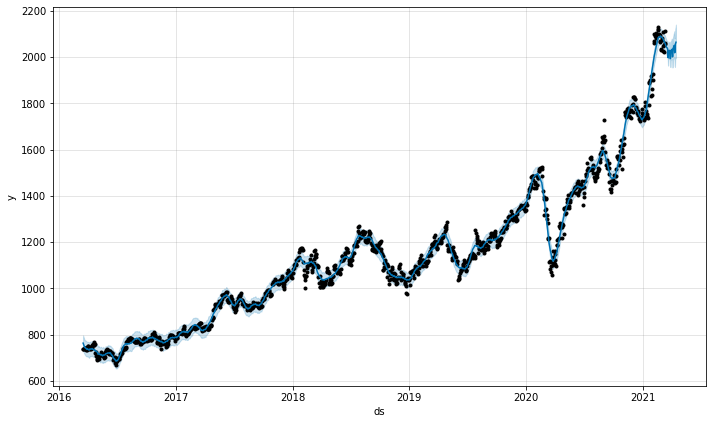

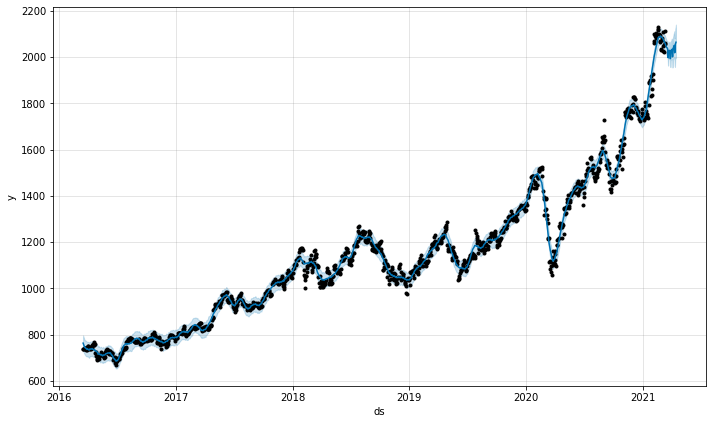

In [71]:
forecast=m.predict(df)
m.plot(forecast)

In [72]:
forecast['yhat']

0        762.933814
1        759.080609
2        755.172887
3        744.583113
4        743.602184
           ...     
1283    2018.837720
1284    2021.459800
1285    2056.177972
1286    2060.003223
1287    2064.553345
Name: yhat, Length: 1288, dtype: float64